In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm.notebook import tqdm

# Define SImplicial Trees and Depth Posets

In [3]:
def get_random_reordered_stree(stree, change=1.):
    order = np.array([simplex for simplex, value in stree.get_filtration()], dtype=object)
    dims = np.array([len(s) for s in order])
    new_order = []
    for dim in np.unique(dims):
        order_dim = order[dims == dim]
        old_index_change = np.random.choice(np.arange(len(order_dim)), int(change*len(order_dim)), replace=False)
        new_index_change = np.random.choice(old_index_change, len(old_index_change), replace=False)
        order_dim[old_index_change] = order_dim[new_index_change]
        new_order.extend(order_dim)
        
    new_stree = gh.SimplexTree()
    for value, simplex in enumerate(new_order):
        new_stree.insert(simplex, value)
    return new_stree

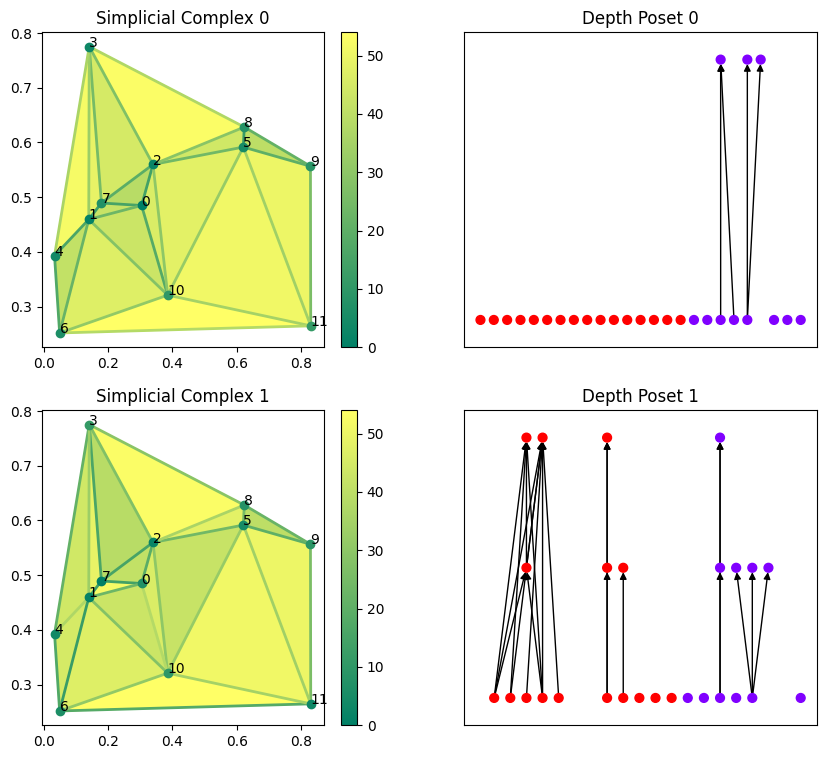

In [4]:
n = 12
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
order = []
for d in range(dim + 1):
    for simplex, value in stree.get_filtration():
        if len(simplex) == d + 1:
            order.append(simplex)
stree0 = gh.SimplexTree()
for value, simplex in enumerate(order):
    stree0.insert(simplex, value)

dp0 = DepthPoset.from_simplex_tree(stree0)


stree1 = get_random_reordered_stree(stree0, change=0.5)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(10, 9))

for i, (stree, dp) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Simplicial Complex {i}')
    sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[i, 0])
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])
    
    axs[i, 1].set_title(f'Depth Poset {i}')
    cmap = plt.get_cmap('rainbow')
    node_colors = [cmap(node.dim/(dim - 1)) for node in dp0.nodes]
    nx.draw_networkx(dp.get_transitive_closure(), dp.hasse_layout(), 
                     node_color=node_colors, node_size=40, with_labels=False,
                     ax=axs[i, 1])

plt.show()

In [5]:
df_filtrations = pd.DataFrame({'Complex 0': {str(key): value for key, value in stree0.get_filtration()}, 
                               'Complex 1': {str(key): value for key, value in stree1.get_filtration()}})
#df_filtrations[df_filtrations['Complex 0'] != df_filtrations['Complex 1']]
pd.Series({ord: np.linalg.norm(df_filtrations['Complex 1'] - df_filtrations['Complex 0'], ord=ord) for ord in [0, np.inf]})

0.0    24.0
inf    21.0
dtype: float64

# Depth Poset Difference Scores

## Special Scores

In [6]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

In [7]:
def hausdorff_distance(x, y, metric='euclidean') -> float:
    """
    The Hausdorf Distance between 2 sets

    Parameters:
    -----------
    x: np.ndarray shape (n0, d)
    
    y: np.ndarray shape (n1, d)
    """
    x = np.asarray(x)
    y = np.asarray(y)

    dist_matrix = sp.spatial.distance.cdist(x, y, metric=metric)

    return max(dist_matrix.min(axis=1).max(), dist_matrix.min(axis=0).max())


## Comparing Cells

In [8]:
def jacard_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of cells sets represented in 2 Depth Posets.
    """
    cells0 = [node.source[0] for node in dp0.nodes] + [node.source[1] for node in dp0.nodes]
    cells1 = [node.source[0] for node in dp1.nodes] + [node.source[1] for node in dp1.nodes]
    return jacard_index(cells0, cells1)

In [9]:
jacard_cells(dp0, dp1)

0.9636363636363636

In [10]:
def jacard_nodes_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([node.source for node in dp0.nodes], [node.source for node in dp1.nodes])

In [11]:
jacard_nodes_cells(dp0, dp1)

0.2857142857142857

In [12]:
def jacard_edges_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([(node0.source, node1.source) for node0, node1 in dp0.edges], 
                        [(node0.source, node1.source) for node0, node1 in dp1.edges])
    

In [13]:
jacard_edges_cells(dp0, dp1)

0.0

## Comparing Index

In [14]:
def jacard_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [15]:
jacard_nodes_bd_index(dp0, dp1)

0.125

In [16]:
def jacard_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [17]:
jacard_edges_bd_index(dp0, dp1)

0.0

In [18]:
def hausdorff_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [19]:
hausdorff_nodes_bd_index(dp0, dp1)

np.float64(8.48528137423857)

In [20]:
def hausdorff_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [21]:
hausdorff_edges_bd_index(dp0, dp1)

np.float64(54.57105459856901)

## Comparing Values

In [22]:
def jacard_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death values sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [23]:
jacard_nodes_bd_values(dp0, dp1)

0.125

In [24]:
def jacard_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [25]:
jacard_edges_bd_values(dp0, dp1)

0.0

In [26]:
def hausdorff_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [27]:
hausdorff_nodes_bd_values(dp0, dp1)

np.float64(8.48528137423857)

In [28]:
def hausdorff_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [29]:
hausdorff_edges_bd_values(dp0, dp1)

np.float64(54.57105459856901)

# Set of Filtrations

## Random Model Description and Generating

### Set Parameters

In [30]:
n_filtrations = 20
scale = 0.01
p = 0.1

n = 8
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()

### Model Description

In [31]:
model_description = f'''
\\par For the given simplicial complex, defined by Delaunay triangulation of $n = {n}$ points uniformly distributed in $[0, 1]^{{{dim}}}$
we define the original filtration in the way:
$$
f(s) - \\dim(s) + x, \\; \\text{{where}}\\; x\\sim \\mathcal{{U}}[0, 1]
$$
\\par Then we are defining $n_f = {n_filtrations}$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale {scale}:
$$
f_{{i+1}}(s) = 
\\begin{{cases}}
f_i(s) + x\\sim \\mathcal{{N}}(0, {scale}), \\; \\text{{if}} \\; p < {p} \\\\
f_i(s), \\;  \\text{{if}} \\; p \\geq {p} 
\\end{{cases}}, \\; p\\sim \\mathcal{{U}}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{{norm}}(s) = \\cfrac
{{f_i(s) - \\min\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma)}}
{{\\max\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma) - \\min\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma)}} + \\dim(s)
$$

'''.strip()

print(model_description)

\par For the given simplicial complex, defined by Delaunay triangulation of $n = 8$ points uniformly distributed in $[0, 1]^{2}$
we define the original filtration in the way:
$$
f(s) - \dim(s) + x, \; \text{where}\; x\sim \mathcal{U}[0, 1]
$$
\par Then we are defining $n_f = 20$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale 0.01:
$$
f_{i+1}(s) = 
\begin{cases}
f_i(s) + x\sim \mathcal{N}(0, 0.01), \; \text{if} \; p < 0.1 \\
f_i(s), \;  \text{if} \; p \geq 0.1 
\end{cases}, \; p\sim \mathcal{U}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{norm}(s) = \cfrac
{f_i(s) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)}
{\max\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)} + \dim(s)
$$


\par For the given simplicial complex, defined by Delaunay triangulation of $n = 8$ points uniformly distributed in $[0, 1]^{2}$
we define the original filtration in the way:
$$
f(s) - \dim(s) + x, \; \text{where}\; x\sim \mathcal{U}[0, 1]
$$
\par Then we are defining $n_f = 20$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale 0.01:
$$
f_{i+1}(s) = 
\begin{cases}
f_i(s) + x\sim \mathcal{N}(0, 0.01), \; \text{if} \; p < 0.2 \\
f_i(s), \;  \text{if} \; p \geq 0.2 
\end{cases}, \; p\sim \mathcal{U}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{norm}(s) = \cfrac
{f_i(s) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)}
{\max\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)} + \dim(s)
$$

### Generate by the Model

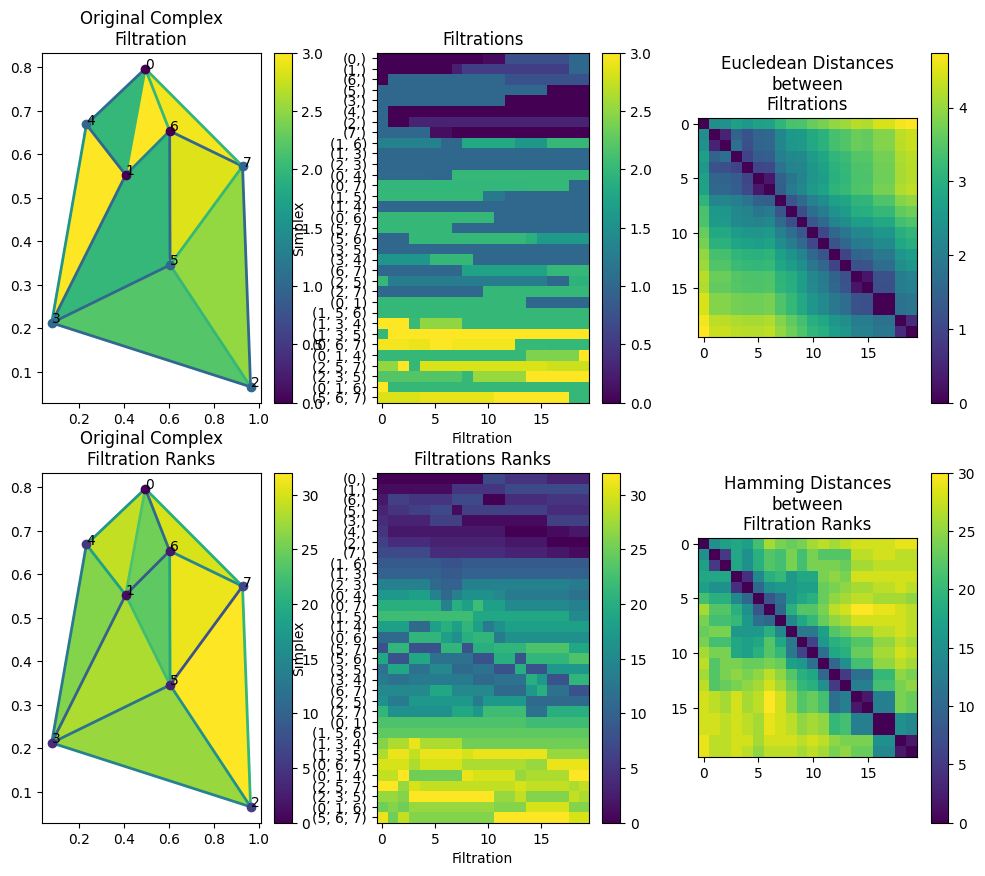

In [32]:
# get simplices and dimensions arrays
simplices = np.array([tuple(s) for s, f_val in stree.get_simplices()], dtype=object)

simplices_dimensions = np.array([len(s) - 1 for s in simplices])
simplices = simplices[simplices_dimensions.argsort()]
simplices_dimensions = np.array([len(s) - 1 for s in simplices])

# generate original filtration
filtrations = np.random.random(len(simplices)) * np.ones([n_filtrations, len(simplices)])

# generate cumulatative normal adding part
filtrations_add = np.random.normal(scale=scale, size=[n_filtrations, len(simplices)])
filtrations_add[0] = 0
filtrations_add[np.random.random(filtrations_add.shape) > p] = 0
filtrations_add = np.cumsum(filtrations_add, axis=0)

# get next filtrations
filtrations = filtrations + filtrations_add
divider = filtrations.max(axis=0) - filtrations.min(axis=0)
divider[divider == 0] = 1
filtrations = (filtrations - filtrations.min(axis=0)) / divider
for d in range(dim + 1):
    filtrations[:, simplices_dimensions == d] += d

# get filtrations_rank
filtrations_rank = filtrations.argsort(axis=1)

# find distances between filtrations
filtrations_distances = cdist(filtrations, filtrations, metric='euclidean')
filtrations_rank_distances = cdist(filtrations_rank, filtrations_rank, metric='hamming')*len(simplices)

# define coresponding simplicial complexes
stree_original = gh.SimplexTree()
for simplex, value in zip(simplices, filtrations[0]):
    stree_original.insert(simplex, value)
stree_original_ranked = gh.SimplexTree()
for simplex, value in zip(simplices, filtrations_rank[0]):
    stree_original_ranked.insert(simplex, value)


# 
fig, axs = plt.subplots(2, 3, figsize=(12, 10))

axs[0, 0].set_title('Original Complex\nFiltration')
sm = plot_filtred_complex2d(stree_original, points, ax=axs[0, 0], cmap='viridis', vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 0])
enumerate_points(points, ax=axs[0, 0])

axs[0, 1].set_title('Filtrations')
sm = axs[0, 1].imshow(filtrations.transpose(), vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 1])
axs[0, 1].set_ylabel('Simplex')
axs[0, 1].set_xlabel('Filtration')
axs[0, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[0, 2].set_title('Eucledean Distances\nbetween\nFiltrations')
sm = axs[0, 2].imshow(filtrations_distances.transpose())
plt.colorbar(sm, ax=axs[0, 2])


axs[1, 0].set_title('Original Complex\nFiltration Ranks')
sm = plot_filtred_complex2d(stree_original_ranked, points, ax=axs[1, 0], cmap='viridis')
plt.colorbar(sm, ax=axs[1, 0])
enumerate_points(points, ax=axs[1, 0])

axs[1, 1].set_title('Filtrations Ranks')
sm = axs[1, 1].imshow(filtrations_rank.transpose())
plt.colorbar(sm, ax=axs[1, 1])
axs[1, 1].set_ylabel('Simplex')
axs[1, 1].set_xlabel('Filtration')
axs[1, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[1, 2].set_title('Hamming Distances\nbetween\nFiltration Ranks')
sm = axs[1, 2].imshow(filtrations_rank_distances.transpose())
plt.colorbar(sm, ax=axs[1, 2])

plt.savefig('pics/Comparing Filtrations - filtrations.png')

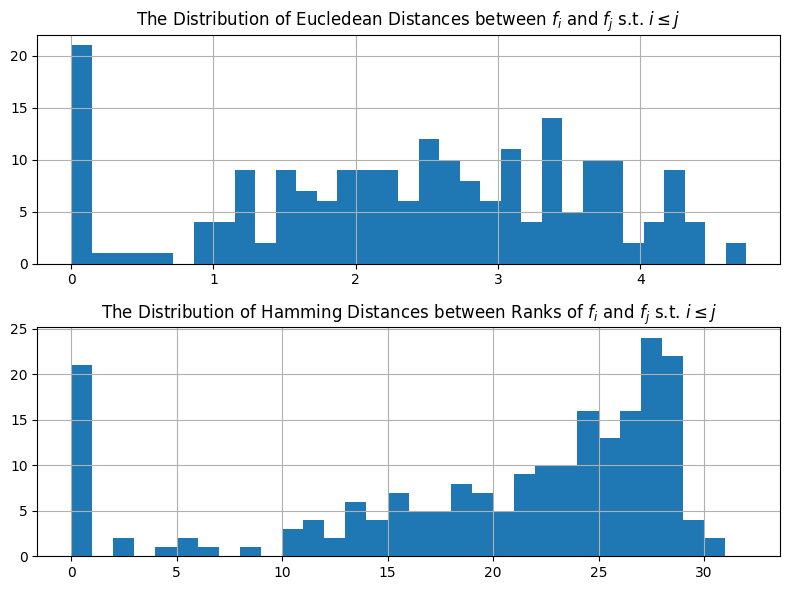

In [33]:
fig, axs = plt.subplots(2, figsize=(8, 6))

axs[0].set_title(r'The Distribution of Eucledean Distances between $f_i$ and $f_j$ s.t. $i \leq j$')
axs[0].hist(filtrations_distances[np.triu(np.ones(filtrations_distances.shape, dtype=bool))], bins=len(simplices))
axs[0].grid(True)

axs[1].set_title(r'The Distribution of Hamming Distances between Ranks of $f_i$ and $f_j$ s.t. $i \leq j$')
axs[1].hist(filtrations_rank_distances[np.triu(np.ones(filtrations_rank_distances.shape, dtype=bool))], 
            bins=np.arange(len(simplices)))
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [34]:
strees = []

# generate simplicial complexes
for i_filtrations in tqdm(range(n_filtrations), total=n_filtrations, desc='Generate Simplex Complexes'):
    filtration = filtrations[i_filtrations]
    strees.append(gh.SimplexTree())
    for simplex, value in zip(simplices, filtration):
        strees[-1].insert(simplex, value)

dps = [DepthPoset.from_simplex_tree(stree) for stree in tqdm(strees, total=n_filtrations, desc='Generate Depth Posets')]

Generate Simplex Complexes:   0%|          | 0/20 [00:00<?, ?it/s]

Generate Depth Posets:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

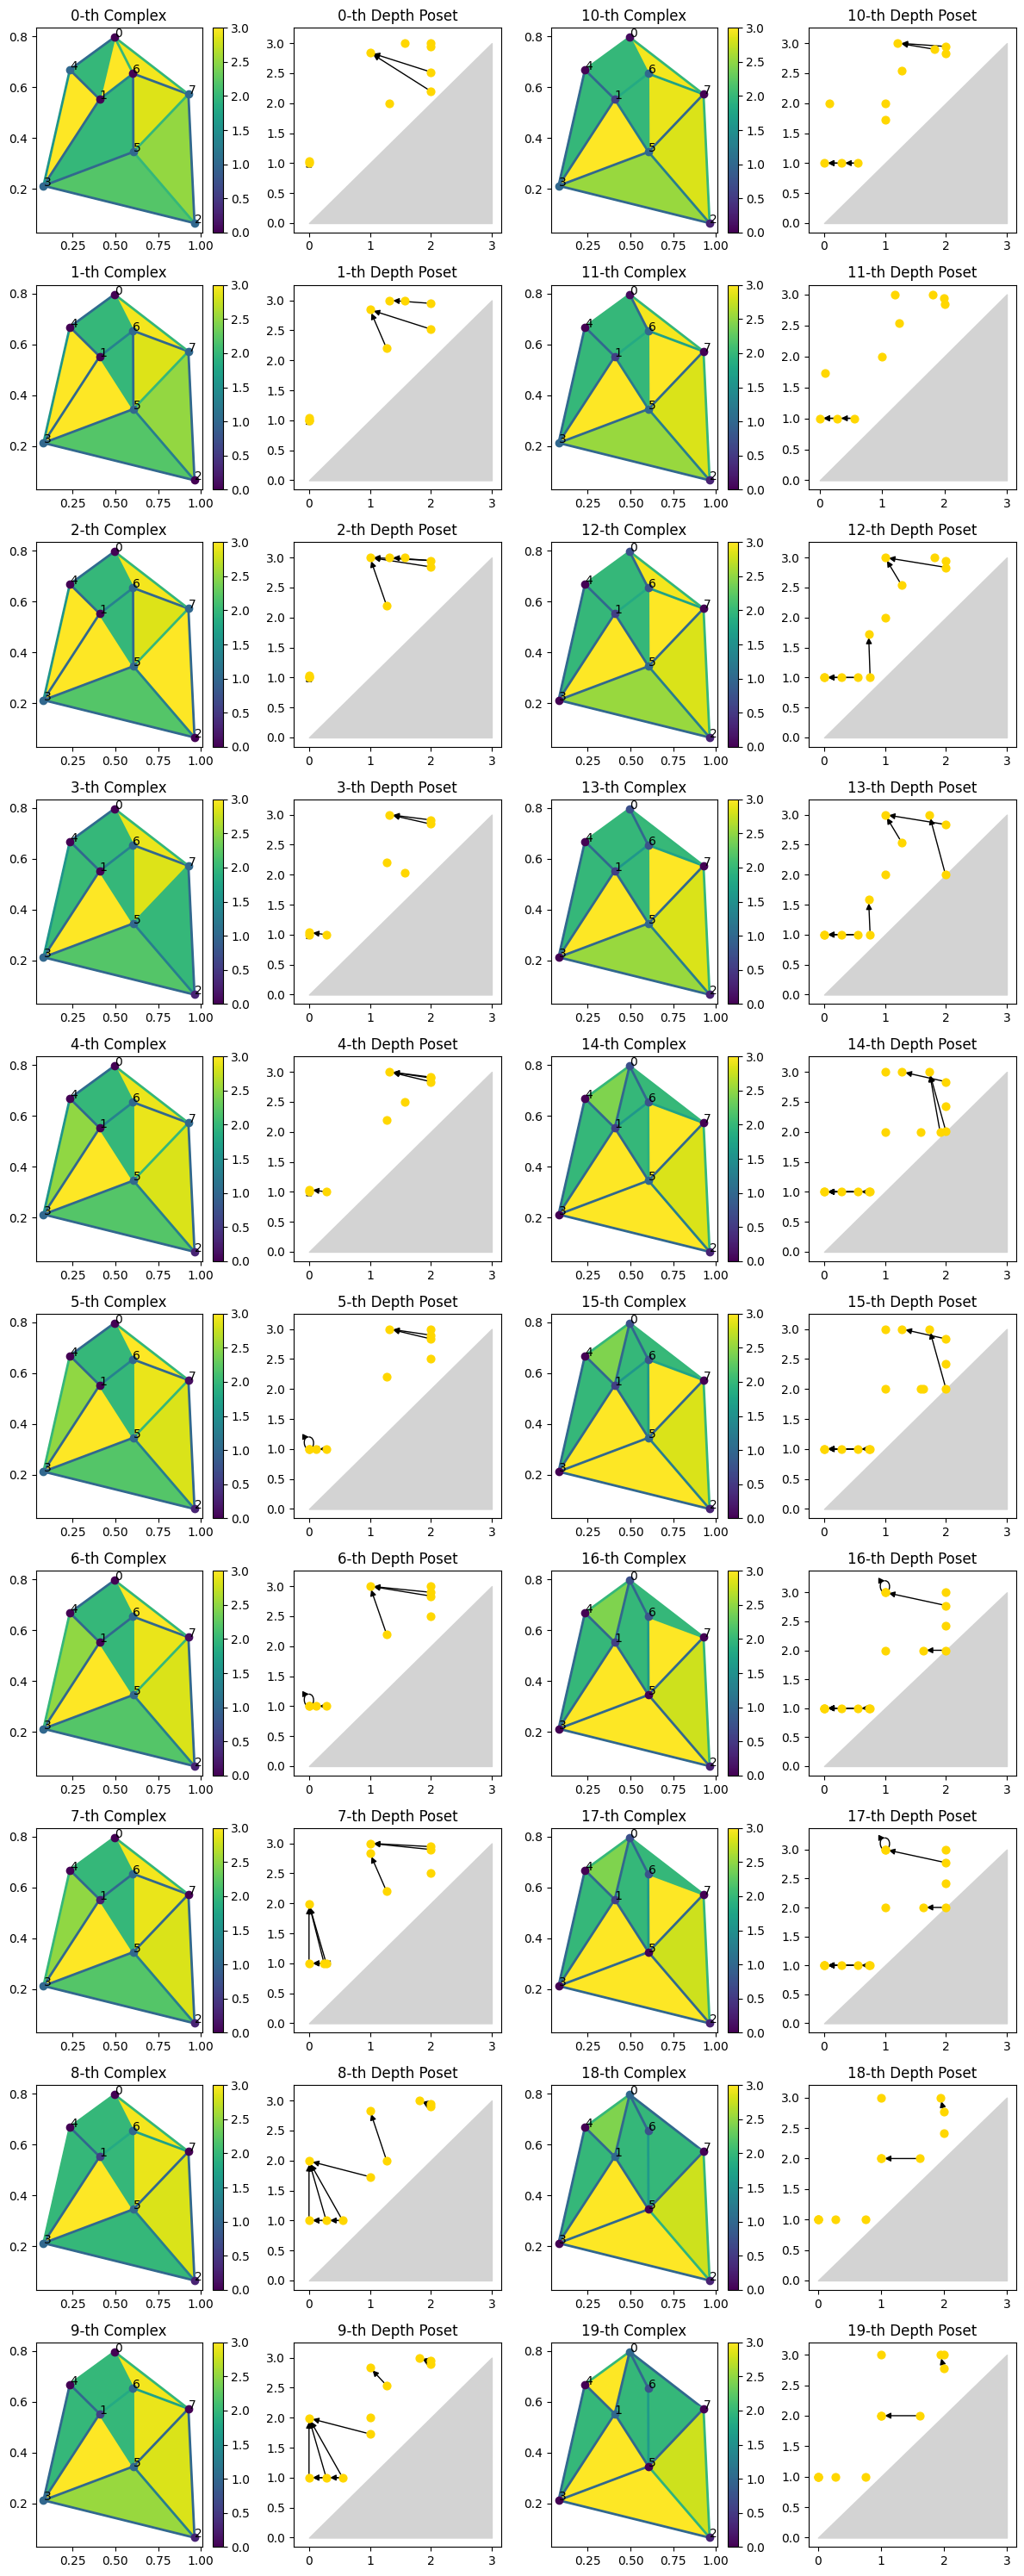

In [35]:
n_rows = int(np.ceil(0.5*n_filtrations))
fig, axs = plt.subplots(n_rows, 4, figsize=(12, n_rows*3))

for i in tqdm(range(n_filtrations), total=n_filtrations):
    i_row = i%n_rows
    i_col = i//n_rows*2
    
    axs[i_row, i_col + 0].set_title(f'{i}-th Complex')
    sm = plot_filtred_complex2d(strees[i], points, ax=axs[i_row, i_col + 0])
    plt.colorbar(sm, ax=axs[i_row, i_col + 0])
    enumerate_points(points, ax=axs[i_row, i_col + 0])
    
    axs[i_row, i_col + 1].set_title(f'{i}-th Depth Poset')
    nx.draw_networkx(dps[i].get_transitive_closure(), dps[i].persistant_layout(), 
                     node_color='gold', node_size=40, with_labels=False,
                     ax=axs[i_row, i_col + 1], hide_ticks=False)
    axs[i_row, i_col + 1].fill_between([filtrations[i].min(), filtrations[i].max()],
                                       [filtrations[i].min(), filtrations[i].min()],
                                       [filtrations[i].min(), filtrations[i].max()],
                                       color='lightgrey')

plt.tight_layout()
plt.savefig('pics/Comparing Filtrations - complexes and depth posets.png')

## Apply Scores

In [36]:
scores_list = [jacard_cells, 
               jacard_nodes_cells, 
               jacard_edges_cells, 
               jacard_nodes_bd_index, 
               jacard_edges_bd_index, 
               hausdorff_nodes_bd_index, 
               hausdorff_edges_bd_index, 
               jacard_nodes_bd_values, 
               jacard_edges_bd_values, 
               hausdorff_nodes_bd_values, 
               hausdorff_edges_bd_values, 
              ]
len(scores_list)

11

In [37]:
cdists = np.nan*np.empty([len(scores_list), n_filtrations, n_filtrations], dtype=float)

with tqdm(total=np.prod(cdists.shape)) as pbar:
    for i, j in itertools.product(range(n_filtrations), repeat=2):
        dpi, dpj = dps[i], dps[j]
        for i_score, score in enumerate(scores_list):
            value = score(dpi, dpj)
            cdists[i_score, i, j] = value
            pbar.update()

  0%|          | 0/4400 [00:00<?, ?it/s]

In [38]:
assert (cdists.transpose([0, 2, 1]) == cdists).all()

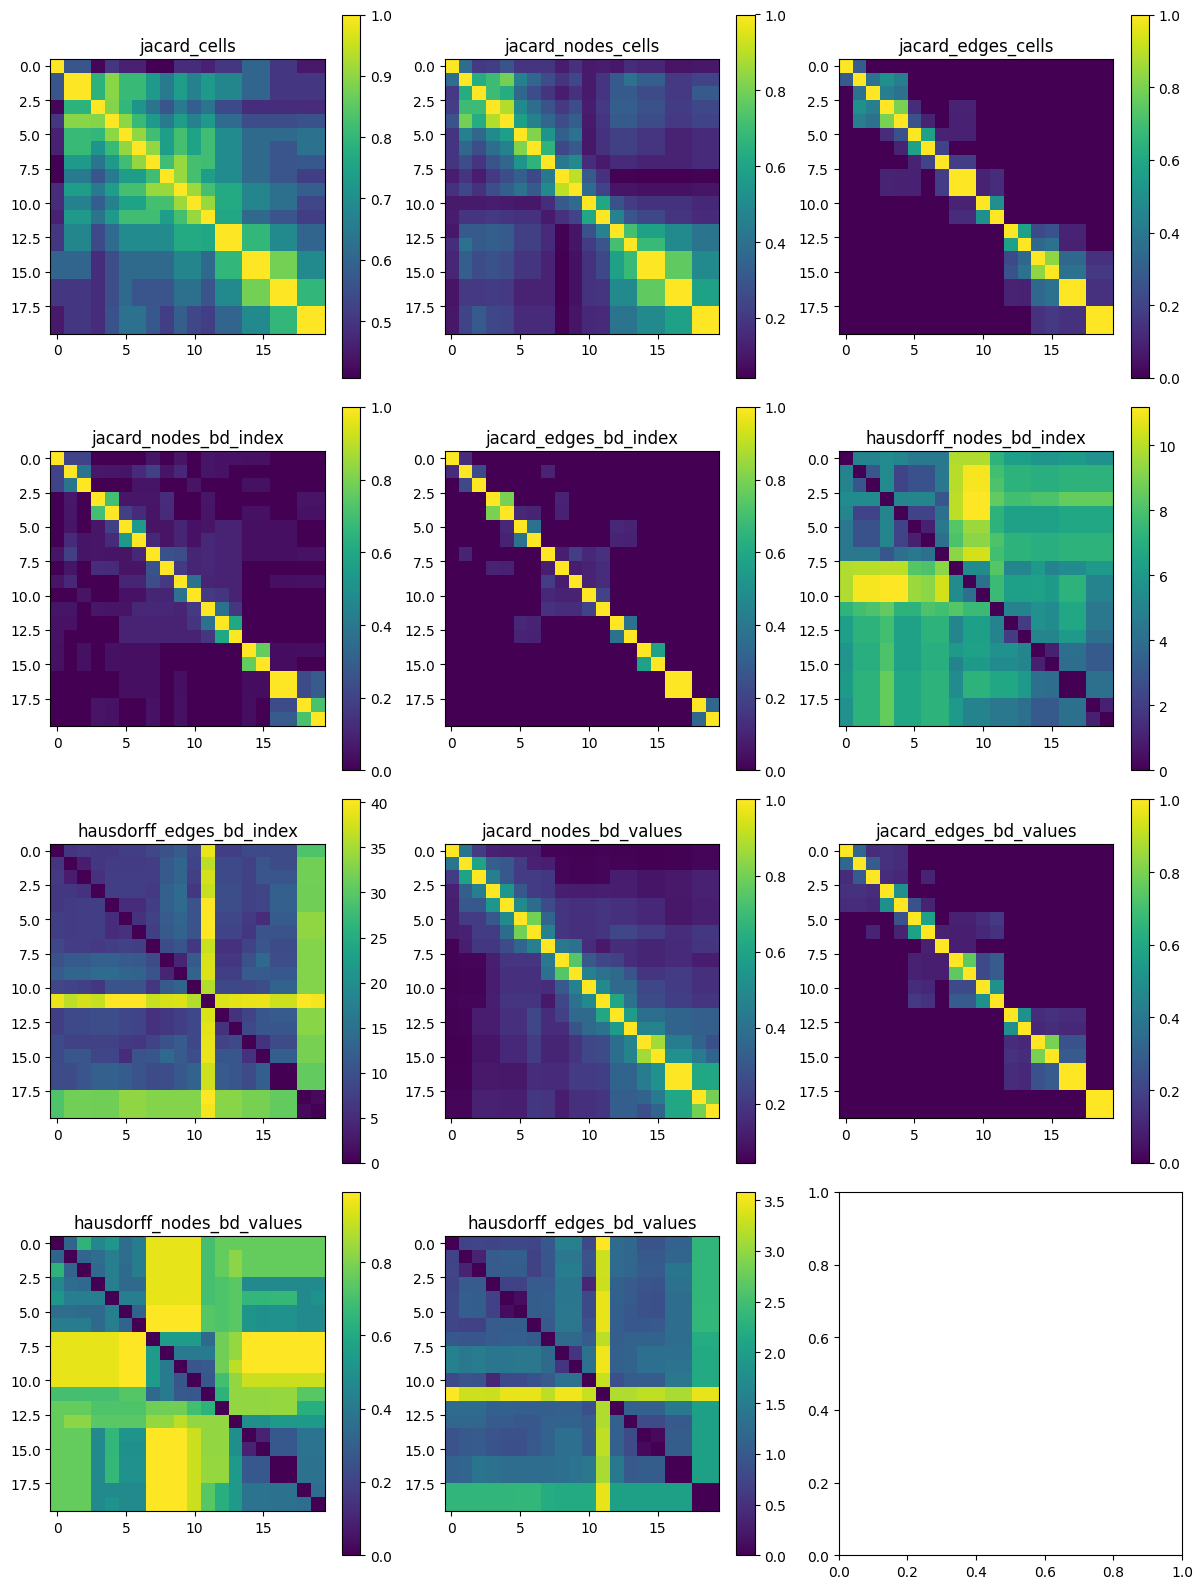

In [39]:
n_elements = len(scores_list)# + 2
n_cols = int(np.ceil(n_elements**0.5))
n_rows = int(np.ceil(n_elements/n_cols))


fig, axs = plt.subplots(n_cols, n_rows, figsize=(4*n_rows, 4*n_cols))

for i_score, score in enumerate(scores_list):
    i_row = i_score//n_rows
    i_col = i_score%n_rows

    axs[i_row, i_col].set_title(score.__name__)
    sm = axs[i_row, i_col].imshow(cdists[i_score])
    plt.colorbar(sm, ax=axs[i_row, i_col])

plt.tight_layout()
plt.savefig('pics/Comparing Filtrations - scores.png')